**Neural Chef Assistance**  
**Name: Darren Jer Shien Yee**  
**Student ID: 31237223**

**Implementation of Baseline 1: RNN without Attention**

In [25]:
## Requirements
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


**Implementation of Baseline 1: Language Method imported from RNN code provided in tutorials**

In [26]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

**Implementation of Baseline 1: Unicode and ASCII method to preprocess data**

In [27]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
# Lowercase only (since numerical is crucial here as opposed to lab code)
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = s.replace('\t', ' ')
    return s

**Implementation of Baseline 1: Method to read data from provided CSV**

In [38]:
import pandas as pd

def readRecipeData(file_path, reverse=False):
    # Read the CSV file
    df = pd.read_csv(file_path)
    df.fillna('', inplace=True)
    ingredients = df['Ingredients']
    recipes = df['Recipe']
    pairs = [[normalizeString(ing), normalizeString(rec)] for ing, rec in zip(ingredients, recipes)]
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang('Recipe')
        output_lang = Lang('Ingredients')
    else:
        input_lang = Lang('Ingredients')
        output_lang = Lang('Recipe')
    return input_lang, output_lang, pairs

**Implementation of Baseline 1: Preprocess data and intialise language using the methods above**

In [39]:
def prepareData(reverse=False,max_ingredient = 40,max_recipe = 80):
    input_lang, output_lang, pairs = readRecipeData('Cooking_Dataset/Cooking_Dataset/train.csv', reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    new_pairs = []
    for pair in pairs:
            if len(pair[0].split()) > max_ingredient or len(pair[1].split()) > max_recipe:
                continue  
            input_lang.addSentence(pair[0])
            output_lang.addSentence(pair[1])
            new_pairs.append(pair)
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, new_pairs

input_lang, output_lang, pairs = prepareData(False)
print(random.choice(pairs))

Read 101340 sentence pairs
Counting words...
Counted words:
Ingredients 16022
Recipe 16818
['5 lb flour 1 c  crisco butter shortening 3 c  water 1/4 c  flour', 'add water.blend with a pastry blender.should hold its shape when squeezed.roll into 20 balls and wrap in wax or plastic paper.drop in a sealable plastic bag for freezer.makes 20 pie crusts . put into a microwave on high for 20 to 30 seconds , turning over once during thawing process.easy to roll out .']


**Implementation of Baseline 1: Encoder RNN for seq2seq model without attention**

In [30]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)


**Implementation of Baseline 1: Decoder RNN for seq2seq model without attention**

In [31]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)


**Implementation of Baseline 1: Train method for seq2seq model without attention**

In [32]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=200):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


**Implementation of Baseline 1: Time method for train iter method** 

In [33]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

**Implementation of Baseline 1: Processing methods for train iter**

In [34]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

**Implementation of Baseline 1: Show Plot method**

In [41]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
    
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


**Implementation of Baseline 1: Train iter method**

In [35]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


**Implementation of Baseline 1: Creating instance of baseline 1 and training**

In [40]:
hidden_size = 256
baseline1_encoder = EncoderRNN(input_lang.n_words, hidden_size, num_layers=1).to(device)
baseline1_decoder = DecoderRNN(hidden_size,output_lang.n_words, num_layers=1).to(device)

trainIters(baseline1_decoder, baseline1_decoder, 10000, print_every=1000)

1m 23s (- 12m 28s) (1000 10%) 10.7185
2m 42s (- 10m 50s) (2000 20%) 11.1982
3m 59s (- 9m 18s) (3000 30%) 11.0558
5m 14s (- 7m 52s) (4000 40%) 11.3257
6m 31s (- 6m 31s) (5000 50%) 11.5339
7m 46s (- 5m 11s) (6000 60%) 11.3127
9m 1s (- 3m 51s) (7000 70%) 10.3275
10m 18s (- 2m 34s) (8000 80%) 10.5818


KeyboardInterrupt: 

**Implementation of Baseline 1: Evaluation methods to check performance of baseline 1**

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=200):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [250]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words= evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [251]:
evaluateRandomly(encoder1, decoder1)

> hearts of palm pimento strips
= in each heart of palm cut a vee shaped niche . stuff pimento strips into the niche . arrange on a platter the desired numbers . serve with your favourite mustard .
< tomatoes an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an an

**Implementation of Baseline 2: RNN with Attention**

In [57]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=200):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        # self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        # self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        #self.out = nn.Linear(self.hidden_size, self.output_size)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        _, hidden = self.gru(embedded, hidden)

        attn_weights = F.softmax(torch.bmm(hidden, encoder_outputs.T.unsqueeze(0)),dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        output = F.log_softmax(self.out(concat_output), dim=1)

        # attn_weights = F.softmax(
        #     self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # attn_applied = torch.bmm(attn_weights.unsqueeze(0),
        #                          encoder_outputs.unsqueeze(0))

        # output = torch.cat((embedded[0], attn_applied[0]), 1)
        # output = self.attn_combine(output).unsqueeze(0)

        # output = F.relu(output)
        # output, hidden = self.gru(output, hidden)

        # output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


**Implementation of Baseline 2: Train method for RNN with attention**

In [58]:
teacher_forcing_ratio = 0.5
def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=200):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


**Implementation of Baseline 2: Train iter method for RNN with attention**

In [59]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


**Implementation of Baseline 2: Initialising instance of RNN with attention**

1m 18s (- 24m 57s) (1000 5%) 6.0989
2m 36s (- 23m 26s) (2000 10%) 5.3005
3m 58s (- 22m 33s) (3000 15%) 5.2629
9m 45s (- 39m 2s) (4000 20%) 5.1782
18m 17s (- 54m 53s) (5000 25%) 4.8102
28m 48s (- 67m 14s) (6000 30%) 4.8739
30m 14s (- 56m 9s) (7000 35%) 4.8303
31m 36s (- 47m 25s) (8000 40%) 4.7073
33m 2s (- 40m 22s) (9000 45%) 4.7165
34m 23s (- 34m 23s) (10000 50%) 4.7422
35m 43s (- 29m 13s) (11000 55%) 4.6266
37m 5s (- 24m 43s) (12000 60%) 4.6965
38m 27s (- 20m 42s) (13000 65%) 4.7882
39m 48s (- 17m 3s) (14000 70%) 4.7253
41m 7s (- 13m 42s) (15000 75%) 4.6179
42m 30s (- 10m 37s) (16000 80%) 4.7649
43m 53s (- 7m 44s) (17000 85%) 4.7134
45m 16s (- 5m 1s) (18000 90%) 4.6393
46m 39s (- 2m 27s) (19000 95%) 4.5755
48m 3s (- 0m 0s) (20000 100%) 4.6001


<Figure size 640x480 with 0 Axes>

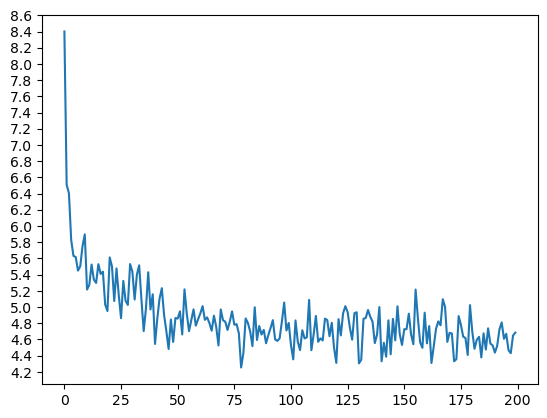

In [45]:
hidden_size = 256
baseline2_encoder = EncoderRNN(input_lang.n_words, hidden_size,num_layers = 1).to(device)
baseline2_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters_attn(baseline2_encoder, baseline2_decoder, 20000, print_every=1000)

**Implementation of Baseline 2: Evaluation method for RNN with Attention**

In [46]:
def evaluate_attn(encoder, decoder, sentence, max_length=200):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [47]:
def evaluateRandomly_attn(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= evaluate_attn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [49]:
evaluateRandomly_attn(baseline2_encoder, baseline2_decoder)

> 3/4 c  sugar 1/3 c  catsup 1 c  oil 1    onion grated (or onion 2 tb worcestershire sauce -flakes) 1/4 c  vinegar pinch of salt 1 pk spinach 8    slices bacon, fried & 2    eggs, boiled & chopped crumbled
= mix dressing ingredients . clean and tear spinach . pour dressing over spinach and add bacon and eggs before serving . serves 6-8 .
< in all in a bowl , . add salt and pepper the in a . and before serving . before serving . before serving , and before serving . <EOS>

> 4 c  yogurt, unflavoured 4 ea cloves garlic, crushed 2 t  olive oil 1/2 t  dried dillweed 1 ea salt, pepper
= place a piece of cheesecloth in a colander and pour in the yogurt . drain for several hours . place grated cucumber in another colander and allow to drain for 2 hours . mix together all ingredients , chill . drizzle additional olive oil on top . serve as a dip for vegetables , or a spread for bread .
< in a , and the and to . . heat add . and , and and . minutes . . . . . <EOS>

> 1 md onion, chopped 2    c

In [277]:
class EncoderRNN_Layers(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(EncoderRNN_Layers, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)


In [282]:
class AttnDecoderRNN_Layers(nn.Module):
    def __init__(self, hidden_size, output_size,num_layers, dropout_p=0.1, max_length=200):
        super(AttnDecoderRNN_Layers, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.num_layers = num_layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, num_layers=self.num_layers)
        self.out = nn.Linear(self.hidden_size*2, self.output_size)
        self.iteration = 0

    def forward(self, input, hidden, encoder_outputs):
        self.iteration += 1
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        _, hidden = self.gru(embedded, hidden)
        attn_weights = F.softmax(torch.bmm(hidden[-1].unsqueeze(0), encoder_outputs.T.unsqueeze(0)),dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        output = F.log_softmax(self.out(concat_output), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)


In [283]:
def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=200):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    # Initialize decoder hidden state for each layer
    decoder_hidden = encoder_hidden.new_zeros(decoder.num_layers, 1, decoder.hidden_size)
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach().unsqueeze(0)  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [284]:
def trainIters_attn_layers(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_attn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [ ]:
hidden_size = 256
more_layers_encoder = EncoderRNN_Layers(input_lang.n_words, hidden_size,num_layers = 3).to(device)
more_layers_decoder = AttnDecoderRNN_Layers(hidden_size, output_lang.n_words,3, dropout_p=0.1).to(device)

trainIters_attn_layers(more_layers_encoder, more_layers_decoder, 50000, print_every=5000)